# MLP for timeseries example

This notebooks provides an example on how to create a timeseries model (MLP) with SAM.

The timeseries model utilizes the feature engineering capabilities of SAM. To learn more about feature engineering, see the notebook `feature_engineering.ipynb` and the [Feature Engineering](https://sam.nist.gov/docs/feature-engineering) section of the SAM documentation.

In [1]:
from sam.models import MLPTimeseriesRegressor
from sam.feature_engineering import SimpleFeatureEngineer

import pandas as pd

2022-07-28 11:56:06.033825: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-28 11:56:06.033872: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data = pd.read_parquet("../data/rainbow_beach.parquet")
data.head()

,batttery_life,transducer_depth,turbidity,water_temperature,wave_height,wave_period
TIME,,,,,,
2014-06-15 00:00:00,11.6,1.495,0.85,16.6,0.136,3.0
2014-06-15 01:00:00,11.6,1.420,0.87,16.3,0.117,4.0
2014-06-15 02:00:00,11.6,1.478,0.79,16.1,0.114,7.0
2014-06-15 03:00:00,11.6,1.518,0.76,15.9,0.111,3.0
2014-06-15 04:00:00,11.6,1.507,0.77,15.7,0.107,3.0


To use the model, we need a feature engineering transformer. `sam.feature_engineering` contains a number of transformers that can be used to create features from the data, suitable for time series problems.

In [3]:
simple_features = SimpleFeatureEngineer(
    rolling_features=[
        ("wave_height", "mean", 48),
        ("wave_height", "mean", 24),
        ("wave_height", "mean", 12),
    ],
    time_features=[
        ("hour_of_day", "cyclical"),
        ("day_of_week", "cyclical"),
    ],
    keep_original=False,
)

X = data
y = data["water_temperature"]


The following example creates a model for nowcasting (predicting the current value of a certain variable).

In [4]:
model = MLPTimeseriesRegressor(
    predict_ahead=(0,),
    feature_engineer=simple_features,
    use_diff_of_y=False,
    epochs=20,
    verbose=0
)

model.fit(X, y)

2022-07-28 11:56:09.589161: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-28 11:56:09.589448: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-28 11:56:09.589502: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (L17646): /proc/driver/nvidia/version does not exist
2022-07-28 11:56:09.590332: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<AxesSubplot:xlabel='TIME'>

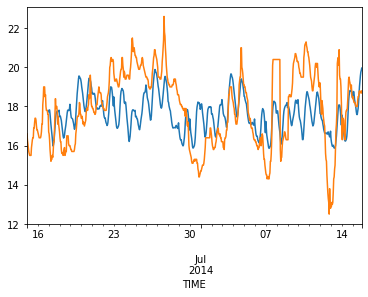

In [5]:
model.predict(X, y).plot()
y.plot()

To create a forecasting model, one can choose `predict_ahead` differently. Choose a tuple of multiple values to predict multiple timesteps ahead. Also, the parameter `use_diff_of_y` can be useful in forecasting applications.

In [6]:
model = MLPTimeseriesRegressor(
    predict_ahead=(1, 2, 3),
    feature_engineer=simple_features,
    use_diff_of_y=True,
    epochs=20,
    verbose=0,
)

model.fit(X, y)


## Using a pipeline for feature engineering

Time series models in SAM should support any scikit-learn pipeline. For example a pipeline that includes a feature engineering transformer and an imputation transformer.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

simple_features = SimpleFeatureEngineer(
    rolling_features=[
        ("wave_height", "mean", 48),
        ("wave_height", "mean", 24),
        ("wave_height", "mean", 12),
    ],
    time_features=[
        ("hour_of_day", "cyclical"),
        ("day_of_week", "cyclical"),
    ],
    keep_original=False,
)

feature_pipeline = Pipeline(steps=[
    ('feature_engineer', simple_features),
    ('imputer', SimpleImputer(strategy='mean')),
])


model = MLPTimeseriesRegressor(
    predict_ahead=(0,),
    feature_engineer=feature_pipeline,
    use_diff_of_y=False,
    epochs=20,
    verbose=0
)

model.fit(X, y)

<AxesSubplot:xlabel='TIME'>

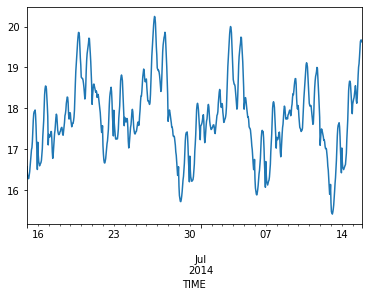

In [8]:
model.predict(X, y).plot()